# Prédictions à partir de la première Base de Données

Dans un premier temps, nous allons tenter de prédire les résultats de Ligue 1 pour la saison en cours, à partir d'une base de donnée constituée de certaines données basiques sur l'ensemble des saisons depuis 2002-2003. Ces données seront, pour chaque match: la journée, le lieu du match, les deux équipes, le score, le classement des deux équipes. A partir de ces données nous allons pouvoir créer différents indicateurs comme la moyenne de buts marqués ou encore la forme des équipes et essayer de prédire les futures résultats. 

In [2]:
import pandas as pd
import numpy as np 
import openpyxl
import sklearn.linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier  
from sklearn.ensemble import RandomForestRegressor  
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import requests
import re
from IPython.display import display


## Scrapping des données 

Nous commençons par scrapper nos données. Nous scrappons d'abord l'ensemble des résultats sur le site *fbref.com*. Nous créons à partir de ce scrapping un **DataFrame** avec 7 colonnes:

la saison, la journée, l'équipe domicile, l'équipe extérieur, le nombre de buts de l'équipe domicile, le nombre de buts de l'équipe extérieure et le résultat (1 = victoire domicile, 0 = match nul, -1 = victoire extérieur)

On enregistre le **DataFrame** au format csv.

In [3]:
def fonction_resultats(i):
    url = 'https://fbref.com/en/comps/13/' + str(i) +'-' + str(i+1) + '/schedule/' + str(i) +'-' + str(i+1) + '-Ligue-1-Scores-and-Fixtures' #url de la page à scraper
    page = requests.get(url)
    html_content = page.content
    soup = BeautifulSoup(html_content, 'html.parser')
    table = soup.find('table')
    if i == 2023:
        df = pd.read_html(str(table))[0].dropna(subset = 'Wk').reset_index(drop=True) #on récupère le tableau des résultats avec un petite exception pour la saison en cours qui nous sera utile plus tard
        df['Wk'] = df['Wk'].astype(int)
        affiches = df[df['Score'].isna()]
    else:
        df = pd.read_html(str(table))[0].dropna(subset = 'Wk').dropna(subset = 'Score').reset_index(drop=True) 
    df = df[['Wk', 'Home', 'Score', 'Away']]                                            #on garde seulement les colonnes utiles
    noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']
    df.insert(0,'Saison', str(i) + '-' + str(i+1))                                      #on ajoute la saison
    df['Buts domicile'] = df['Score'].str.split('–').str[0].apply(lambda x: 0 if pd.isna(x) else int(x)).astype(int)    #on transforme les score en buts domicile et extérieur
    df['Buts extérieur'] = df['Score'].str.split('–').str[1].apply(lambda x: 0 if pd.isna(x) else int(x)).astype(int)
    df.drop(['Score'], axis = 1, inplace = True)
    df['Résultat'] = -1                                                        #on ajoute la colonne résultat qui vaut 1 si le domicile gagne, 0 si match nul et -1 si l'extérieur gagne
    df.loc[df['Buts domicile'] > df['Buts extérieur'], 'Résultat'] = 1
    df.loc[df['Buts domicile'] == df['Buts extérieur'], 'Résultat'] = 0
    df.columns = noms_colonnes                                                  #on renomme les colonnes
    df['Journée'] = df['Journée'].astype(int)
    return df

noms_colonnes = ['Saison','Journée','Domicile','Extérieur','Buts domicile','Buts extérieur','Résultat']     #on crée un dataframe vide qui contiendra tous les résultats de la Ligue 1 depuis 2002
dataframe_resultats = pd.DataFrame(columns=noms_colonnes)
for i in range (2002, 2023):                                                                                #on utilise la fonction précédente pour récupérer les résultats de chaque saison
    try:
        resultats_finaux = fonction_resultats(i)
        dataframe_resultats = dataframe_resultats._append(resultats_finaux, ignore_index=True)
    except Exception as e:
        print(f"Erreur à l'élément {i}: {e}")

dataframe_resultats.to_csv('dataframe_résultats.csv', encoding = 'utf-8', index=False)              #on sauvegarde le dataframe des résultats de ligue 1 de 2002-2003 à 2022-2023 dans un fichier csv


Erreur à l'élément 2002: cannot access local variable 'affiches' where it is not associated with a value
Erreur à l'élément 2003: cannot access local variable 'affiches' where it is not associated with a value


KeyboardInterrupt: 

## Création du **DataFrame** final pour l'implémentation de modèles prédictifs

A partir de ce **DataFrame**, nous créons un nouveau **DataFrame** avec l'ensemble des informations que nous souhaitions avoir pour tenter de prédire les résultats futurs. Nous remplaçons 'Equipe à Domicile', 'Equipe à l'extérieur' par 'Equipe 1', 'Equipe 2', nous ajoutons une colonne valant si l'Equipe 1 est à domicile, 0 sinon, et nous créons un double de notre **DataFrame** en inversant Equipe 1 et Equipe 2, puis nous ajoutons les deux **DataFrame** de sorte à avoir, pour chaque équipe, l'ensemble de ses matchs en tant qu'Equipe 1. Ensuite nous ajoutons le classement à chaque journée des équipes de sorte à avoir pour chaque match le classement des deux équipes avant le match. Nous créons alors les colonnes suivantes : 'Moyenne buts marqués par 1', 'Moyennes buts marqués par 2', 'Moyenne buts marqués par 1 à domicile', 'Moyenne buts marqués par 1 à l'extérieur', 'Moyenne buts marqués par 2 à domicile', 'Moyenne buts marqués par 2 à l'extérieur', 'Moyenne buts encaissés par 1', 'Moyenne buts encaissés par 2','Moyenne buts encaissés par 1 à domicile', 'Moyenne buts encaissés par 1 à l'extérieur', 'Moyenne buts encaissés par 2 à domicile', 'Moyenne buts encaissés par 2 à l'extérieur', 'Forme Equipe 1', 'Forme Equipe 2' et  'Historique des confrontations'. La forme est un indicateur sur les 5 derniers matchs d'une équipe dans la saison, simplement en faisant la somme des résultats. 

*Avec notre fonction nous pouvons choisir d'avoir les indicateurs avant ou après le match. Le **DataFrame** avec les indicateurs avant le match nous sera utile pour les prédictions. Celui après le match est plus adapté aux statistiques descriptives puisqu'il n'y a pas la perte de donnée du dernier match de chaque saison.*

In [128]:
def fonction_prepa_base (dataframe_final, i): #on crée une fonction pour créer les indicateurs qui nous intéressent. Le paramètre i vaut 1 si on souhaite avoir les indicateurs avant le match, 0 si après
    dataframe_final.insert(4, 'Equipe 1 à Domicile', 1)             #on ajoute une colonne qui vaut 1 si l'équipe 1 joue à domicile, 0 sinon
    noms_colonnes = ['Saison', 'Journée', 'Equipe 1', 'Equipe 2', 'Equipe 1 à Domicile', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat']
    dataframe_final.columns = noms_colonnes             #on renomme les colonnes. Il n'y a plus de Domicile et d'extérieur mais seulement Equipe 1 et Equipe 2
    dataframe_final_copie = dataframe_final.copy()[['Saison', 'Journée', 'Equipe 2', 'Equipe 1', 'Equipe 1 à Domicile', 'Buts Equipe 2', 'Buts Equipe 1', 'Résultat']] #on crée une copie en inversant Equipe 1 et Equipe 2
    dataframe_final_copie.columns = noms_colonnes
    dataframe_final_copie['Equipe 1 à Domicile'] = 0
    dataframe_final = dataframe_final._append(dataframe_final_copie, ignore_index=True)    #On fait en sorte que chaque équipe est tous ses matchs en tant qu'Equipe 1
    dataframe_final = dataframe_final.sort_values(by=['Saison', 'Equipe 1', 'Journée']).reset_index(drop=True)
    conditions = [                                                                         #On remplace de nouveau les résultats par 1 si victoire, 0 si nul et -1 si défaite
        (dataframe_final['Buts Equipe 1'] > dataframe_final['Buts Equipe 2']),
        (dataframe_final['Buts Equipe 1'] < dataframe_final['Buts Equipe 2'])
    ]
    valeurs = [1, -1]
    dataframe_final['Résultat'] = 0
    dataframe_final['Résultat'] = np.select(conditions, valeurs)


    dataframe_final['Diff'] = dataframe_final['Buts Equipe 1']- dataframe_final['Buts Equipe 2']   #On crée une colonne qui contient la différence de buts
    dataframe_final['Points'] = dataframe_final['Résultat'].map({1: 3, 0: 1, -1: 0})                #On crée une colonne qui contient le nombre de points

    dataframe_final.sort_values(by=['Saison', 'Journée', 'Equipe 1']).reset_index()        #On crée un groupby qui contient le nombre de points et la diff de buts de chaque équipe à chaque journée
    result = dataframe_final.groupby(['Saison', 'Equipe 1']).agg({
        'Points': 'cumsum',
        'Diff': 'cumsum',
        'Buts Equipe 1': 'cumsum',
        'Buts Equipe 2' : 'cumsum'
    }).reset_index()

    dataframe_final[['CPoints', 'CDiff', 'CButs Equipe 1', 'CButs Equipe 2']] = result[['Points', 'Diff', 'Buts Equipe 1', 'Buts Equipe 2']]
    dataframe_final = dataframe_final.sort_values(by=['Saison', 'Journée', 'CPoints', 'CDiff', 'CButs Equipe 1'], ascending=[True, True, False, False, False]).reset_index()
    dataframe_final['Classement Equipe 1'] = dataframe_final.groupby(['Saison', 'Journée']).cumcount() + 1   #On crée une colonne qui contient le classement de chaque équipe à chaque journée
    dataframe_final['Classement Equipe 1'] = dataframe_final.groupby(['Saison','Equipe 1'])['Classement Equipe 1'].shift(i).astype(pd.Int64Dtype())
    dataframe_final = dataframe_final.sort_values(by=['Saison', 'Equipe 1', 'Journée']).reset_index(drop=True).drop(['index','Points', 'Diff','CPoints', 'CDiff', 'CButs Equipe 1', 'CButs Equipe 2'], axis=1)
    dataframe_final['Classement Equipe 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Classement Equipe 1_y']

    dataframe_final['Moyenne_BM par 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].transform(lambda x: x.shift(i).expanding().mean()) #On crée une colonne qui contient la moyenne de buts marqués par l'équipe 1
    dataframe_final['Moyenne_BM par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1_y']
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BM par 1 à Domicile'] = ( #On crée une colonne qui contient la moyenne de buts marqués par l'équipe 1 à domicile
        (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum() - i*dataframe_final['Buts Equipe 1']) / 
        (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount() +1-i)
    )
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BM par 1 à Domicile'] = (
        (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum()) 
        / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
    )
    dataframe_final['Moyenne_BM par 2 à Domicile'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1 à Domicile_y']
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BM par 1 à Extérieur'] = (    #On crée une colonne qui contient la moyenne de buts marqués par l'équipe 1 à l'extérieur
        (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum() - i*dataframe_final['Buts Equipe 1']) 
        / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount() +1-i)
    )
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BM par 1 à Extérieur'] = (
        (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 1'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 1'].cumsum()) 
        / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
    )
    dataframe_final['Moyenne_BM par 2 à Extérieur'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BM par 1 à Extérieur_y']
    dataframe_final['Moyenne_BE par 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].transform(lambda x: x.shift(i).expanding().mean())
    dataframe_final['Moyenne_BE par 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1_y']
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BE par 1 à Domicile'] = (     #On crée une colonne qui contient la moyenne de buts encaissés par l'équipe 1 à domicile
        (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum() - i*dataframe_final['Buts Equipe 2']) 
        / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount() + 1-i)
    )
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BE par 1 à Domicile'] = (   
        (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum()) 
        / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount())
    )
    dataframe_final['Moyenne_BE par 2 à Domicile'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1 à Domicile_y']
    
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 0, 'Moyenne_BE par 1 à Extérieur'] = (    #On crée une colonne qui contient la moyenne de buts encaissés par l'équipe 1 à l'extérieur
        (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum() - i*dataframe_final['Buts Equipe 2']) 
        / (dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount()+1-i)
    )
    dataframe_final.loc[dataframe_final['Equipe 1 à Domicile'] == 1, 'Moyenne_BE par 1 à Extérieur'] = (
        (dataframe_final.groupby(['Saison', 'Equipe 1'])['Buts Equipe 2'].cumsum() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Buts Equipe 2'].cumsum()) 
        / (dataframe_final.groupby(['Saison', 'Equipe 1'])['Journée'].cumcount() - dataframe_final.groupby(['Saison', 'Equipe 1', 'Equipe 1 à Domicile'])['Journée'].cumcount()))
    dataframe_final['Moyenne_BE par 2 à Extérieur'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Moyenne_BE par 1 à Extérieur_y']
    dataframe_final['Forme 1'] = dataframe_final.groupby(['Saison', 'Equipe 1'])['Résultat'].rolling(window=i+5, min_periods=i+1).sum().reset_index(drop=True) - i*dataframe_final['Résultat'] #On crée une colonne qui contient la forme de l'équipe 1
    dataframe_final['Forme 2'] = dataframe_final.merge(dataframe_final, how='left', left_on=['Saison', 'Journée', 'Equipe 1'], right_on=['Saison', 'Journée', 'Equipe 2'])['Forme 1_y']
    dataframe_final['Historique'] = dataframe_final.groupby(['Equipe 1', 'Equipe 2'])['Résultat'].cumsum() - i*dataframe_final['Résultat']  #On crée une colonne qui contient l'historique des confrontations entre les deux équipes
    if i == 0:          #Pour nos statistques descriptives (indicateurs après le match donc i = 0), on fait quelques changements
        dataframe_final['Résultat'] = dataframe_final['Résultat'].map({1: 'Victoire', 0: 'Nul', -1: 'Défaite'})
        dataframe_final['Equipe 1 à Domicile'] = dataframe_final['Equipe 1 à Domicile'].map({1: 'Domicile', 0: 'Extérieur'})
        dataframe_final = dataframe_final.rename(columns={'Equipe 1 à Domicile': 'Lieu'})
    return dataframe_final


dataframe_resultats = pd.read_csv('dataframe_résultats.csv', encoding = 'utf-8')     #on récupère le dataframe des résultats de ligue 1 de 2002-2003 à 2022-2023
dataframe_stats = fonction_prepa_base(dataframe_resultats, 0)   #On applique la fonction précédente pour avoir notre dataframe qui nous servira pour les statistiques descriptives
dataframe_final = fonction_prepa_base(dataframe_resultats, 1)   #On applique la fonction précédente pour avoir notre dataframe qui nous servira pour les modèles 

dataframe_final.to_csv('dataframe_final.csv', encoding = 'utf-8', index=False)  #On sauvegarde le dataframe dans un fichier csv


## Statistiques descriptives 

Dans cette première approche nous avons beaucoup d'observations mais assez peu de variables en comparaison avec notre deuxième approche. Nous pouvons tout de même visualiser quelques statistiques descriptives. 

*On peut d'abord regarder à quoi ressemble nos deux **DataFrames** avec la première saison de celui pour les statistiques descriptives et les 10 premières lignes pour l'autre*

In [125]:
dataframe_stats.head(38)

,Saison,Journée,Equipe 1,Equipe 2,Lieu,Buts Equipe 1,Buts Equipe 2,Résultat,Classement Equipe 1,Classement Equipe 2,...,Moyenne_BM par 2 à Extérieur,Moyenne_BE par 1,Moyenne_BE par 2,Moyenne_BE par 1 à Domicile,Moyenne_BE par 2 à Domicile,Moyenne_BE par 1 à Extérieur,Moyenne_BE par 2 à Extérieur,Forme 1,Forme 2,Historique
0,2002-2003,1,Ajaccio,Strasbourg,Extérieur,1,1,Nul,9,12,...,NaN,1.000000,1.000000,NaN,1.000000,1.000000,NaN,0.0,0.0,0
1,2002-2003,2,Ajaccio,Guingamp,Domicile,0,2,Défaite,16,4,...,2.000000,1.500000,1.500000,2.000000,3.000000,1.000000,0.000000,-1.0,1.0,-1
2,2002-2003,3,Ajaccio,Paris S-G,Extérieur,2,2,Nul,15,10,...,0.000000,1.666667,0.666667,2.000000,1.000000,1.500000,0.000000,-1.0,1.0,0
3,2002-2003,4,Ajaccio,Sedan,Domicile,1,0,Victoire,13,20,...,0.500000,1.250000,2.000000,1.000000,0.500000,1.500000,3.500000,0.0,-3.0,1
4,2002-2003,5,Ajaccio,Troyes,Extérieur,0,1,Défaite,15,16,...,0.000000,1.200000,1.200000,1.000000,2.000000,1.333333,0.000000,-1.0,-1.0,-1
5,2002-2003,6,Ajaccio,Montpellier,Domicile,0,0,Nul,15,17,...,0.333333,1.000000,0.833333,0.666667,0.333333,1.333333,1.333333,-1.0,-3.0,0
6,2002-2003,7,Ajaccio,Bastia,Extérieur,2,1,Victoire,12,15,...,0.333333,1.000000,1.428571,0.666667,1.000000,1.250000,2.000000,1.0,-1.0,1
7,2002-2003,8,Ajaccio,Sochaux,Domicile,0,1,Défaite,13,7,...,0.800000,1.000000,1.000000,0.750000,1.333333,1.250000,0.800000,0.0,1.0,-1
8,2002-2003,9,Ajaccio,Marseille,Extérieur,1,3,Défaite,17,3,...,1.750000,1.222222,1.000000,0.750000,1.000000,1.600000,1.000000,-2.0,2.0,-1
9,2002-2003,10,Ajaccio,Nantes,Domicile,1,0,Victoire,13,16,...,0.833333,1.100000,1.500000,0.600000,1.500000,1.600000,1.500000,0.0,-3.0,1


In [127]:
dataframe_final.head(10)

,Saison,Journée,Equipe 1,Equipe 2,Equipe 1 à Domicile,Buts Equipe 1,Buts Equipe 2,Résultat,Classement Equipe 1,Classement Equipe 2,...,Moyenne_BM par 2 à Extérieur,Moyenne_BE par 1,Moyenne_BE par 2,Moyenne_BE par 1 à Domicile,Moyenne_BE par 2 à Domicile,Moyenne_BE par 1 à Extérieur,Moyenne_BE par 2 à Extérieur,Forme 1,Forme 2,Historique
0,2002-2003,1,Ajaccio,Strasbourg,0,1,1,0,<NA>,<NA>,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2002-2003,2,Ajaccio,Guingamp,1,0,2,-1,9,7,...,NaN,1.000000,3.000000,NaN,3.000000,1.000000,NaN,0.0,0.0,0
2,2002-2003,3,Ajaccio,Paris S-G,0,2,2,0,16,6,...,0.000000,1.500000,0.000000,2.000000,0.000000,1.000000,0.0,-1.0,1.0,0
3,2002-2003,4,Ajaccio,Sedan,1,1,0,1,15,19,...,1.000000,1.666667,2.333333,2.000000,0.500000,1.500000,6.0,-1.0,-2.0,0
4,2002-2003,5,Ajaccio,Troyes,0,0,1,-1,13,17,...,0.000000,1.250000,1.500000,1.000000,3.000000,1.500000,0.0,0.0,-2.0,0
5,2002-2003,6,Ajaccio,Montpellier,1,0,0,0,15,17,...,0.500000,1.200000,1.000000,1.000000,0.333333,1.333333,2.0,-1.0,-2.0,0
6,2002-2003,7,Ajaccio,Bastia,0,2,1,1,15,12,...,0.333333,1.000000,1.333333,0.666667,0.666667,1.333333,2.0,-1.0,-1.0,0
7,2002-2003,8,Ajaccio,Sochaux,1,0,1,-1,12,10,...,0.750000,1.000000,1.142857,0.666667,1.333333,1.250000,1.0,1.0,1.0,0
8,2002-2003,9,Ajaccio,Marseille,0,1,3,-1,13,4,...,1.750000,1.000000,1.000000,0.750000,1.000000,1.250000,1.0,0.0,2.0,0
9,2002-2003,10,Ajaccio,Nantes,1,1,0,1,17,13,...,1.000000,1.222222,1.555556,0.750000,1.500000,1.600000,1.6,-2.0,-3.0,0


*Affichons ensuites les occurences du nombre de buts marqués par match par une équipe sur toutes les saisons*

In [129]:
display(dataframe_stats.groupby(['Saison'])['Buts Equipe 1'].value_counts().unstack().fillna(0).astype(int))

Buts Equipe 1,0,1,2,3,4,5,6,7,8,9
Saison,,,,,,,,,,
2002-2003,277,251,147,56,24,2,3,0,0,0
2003-2004,250,269,147,62,26,5,1,0,0,0
2004-2005,268,265,152,54,13,7,0,0,1,0
2005-2006,278,273,129,51,25,0,2,1,1,0
2006-2007,250,272,150,71,15,2,0,0,0,0
2007-2008,262,258,141,77,15,5,2,0,0,0
2008-2009,240,273,172,59,16,0,0,0,0,0
2009-2010,241,274,139,68,30,8,0,0,0,0
2010-2011,233,272,177,55,17,5,1,0,0,0


*Puis par équipe*

In [130]:
display(dataframe_stats.groupby(['Equipe 1'])['Buts Equipe 1'].value_counts().unstack().fillna(0).astype(int))

Buts Equipe 1,0,1,2,3,4,5,6,7,8,9
Equipe 1,,,,,,,,,,
Ajaccio,126,113,49,11,5,0,0,0,0,0
Amiens,41,37,18,6,2,0,0,0,0,0
Angers,102,106,59,23,2,2,0,0,0,0
Arles-Avignon,23,11,2,2,0,0,0,0,0,0
Auxerre,135,149,95,24,13,2,0,0,0,0
Bastia,119,104,56,17,8,0,0,0,0,0
Bordeaux,212,270,159,75,27,4,3,0,0,0
Boulogne,19,10,6,3,0,0,0,0,0,0
Brest,82,99,58,10,4,3,0,0,0,0


*Affichons le nombre de journées occupé à chaque place par chaque équipe*

In [131]:
display(dataframe_stats.groupby(['Equipe 1'])['Classement Equipe 1'].value_counts().unstack().fillna(0).astype(int))

Classement Equipe 1,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Equipe 1,,,,,,,,,,,,,,,,,,,,
Ajaccio,0,1,0,2,0,1,4,2,5,7,3,4,20,11,30,29,42,53,45,45
Amiens,0,0,0,0,0,0,0,0,3,1,2,2,16,7,8,20,23,13,8,1
Angers,3,12,11,9,9,6,7,16,23,20,16,39,18,31,12,8,8,7,12,27
Arles-Avignon,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,36
Auxerre,8,19,18,39,34,23,20,12,13,20,14,21,22,27,26,25,29,18,16,14
Bastia,1,3,3,1,5,4,5,7,12,17,25,33,40,34,30,21,12,15,27,9
Bordeaux,27,69,39,43,43,64,71,54,64,47,39,40,38,29,17,18,12,10,13,13
Boulogne,0,0,0,0,0,0,1,2,0,0,1,1,0,1,0,2,1,1,27,1
Brest,2,1,1,1,2,4,4,4,6,9,23,30,31,32,31,23,16,17,10,9


*Affichons les résultats de chaque équipe*

In [132]:
display(dataframe_stats.groupby('Equipe 1')['Résultat'].value_counts().unstack().fillna(0).astype(int))

Résultat,Défaite,Nul,Victoire
Equipe 1,,,
Ajaccio,147,91,66
Amiens,48,31,25
Angers,133,79,82
Arles-Avignon,24,11,3
Auxerre,144,120,154
Bastia,133,80,91
Bordeaux,226,234,290
Boulogne,21,10,7
Brest,113,73,70


*Affichons les résultats en fonction du classement avant le match*

In [133]:
resultats_counts =  dataframe_final.groupby('Classement Equipe 1')['Résultat'].value_counts().unstack().fillna(0).astype(int)
resultats_counts.columns = ['Défaite', 'Nul', 'Victoire']
display(resultats_counts)

,Défaite,Nul,Victoire
Classement Equipe 1,,,
1,144,182,440
2,199,205,363
3,216,198,353
4,221,230,316
5,251,224,292
6,231,218,318
7,265,228,274
8,270,226,271
9,264,231,272


*Affichons les résultats en fonction de Domicile/Extérieur*

In [134]:
display(dataframe_stats.groupby('Lieu')['Résultat'].value_counts().unstack().fillna(0).astype(int))

Résultat,Défaite,Nul,Victoire
Lieu,,,
Domicile,2123,2208,3548
Extérieur,3548,2208,2123


*Affichons le nombre de buts marqué en fonction de Domicile/Extérieur*

In [135]:
display(dataframe_stats.groupby('Lieu')['Buts Equipe 1'].value_counts().unstack().fillna(0).astype(int))

Buts Equipe 1,0,1,2,3,4,5,6,7,8,9
Lieu,,,,,,,,,,
Domicile,1943,2729,1856,873,341,97,33,3,3,1
Extérieur,2883,2805,1439,535,165,39,8,4,0,1


*Affichons les résultats en fonction de la forme des équipes avant le match.*

*La valeur de forme est égale à (nombre de victoires - nombre de défaites) sur les 5 derniers matchs*

In [137]:
resultats_counts =  dataframe_final.groupby('Forme 1')['Résultat'].value_counts().unstack().fillna(0).astype(int)
resultats_counts.columns = ['Défaite', 'Nul', 'Victoire']
display(resultats_counts)

,Défaite,Nul,Victoire
Forme 1,,,
-5.0,84,40,23
-4.0,178,121,138
-3.0,488,302,338
-2.0,751,547,617
-1.0,1032,780,878
0.0,1028,787,1019
1.0,895,728,989
2.0,590,527,680
3.0,326,297,488


*Affichons un tableau à double entrée des historiques entre les équipes.*

*La valeur affichée représente (nombre de victoires - nombre de défaites) de l'Equipe 1 contre l'Equipe 2*

In [138]:
display(pd.pivot_table(dataframe_stats, values='Historique', index='Equipe 1', columns='Equipe 2', aggfunc='last').fillna(0).astype(int))

Equipe 2,Ajaccio,Amiens,Angers,Arles-Avignon,Auxerre,Bastia,Bordeaux,Boulogne,Brest,Caen,...,Paris S-G,Reims,Rennes,Saint-Étienne,Sedan,Sochaux,Strasbourg,Toulouse,Troyes,Valenciennes
Equipe 1,,,,,,,,,,,,,,,,,,,,,
Ajaccio,0,0,2,0,-3,0,-5,0,2,0,...,-5,-1,-5,-4,1,-2,-2,-1,-3,1
Amiens,0,0,-2,0,0,0,-1,0,0,0,...,-4,1,-3,-2,0,0,0,-1,-1,0
Angers,-2,2,0,0,0,2,2,0,0,6,...,-14,-2,-8,-6,0,0,-1,-4,3,0
Arles-Avignon,0,0,0,0,-1,0,-1,0,0,0,...,-2,0,-2,-2,0,-2,0,0,0,-2
Auxerre,3,0,0,1,0,1,-3,0,-2,1,...,-5,-1,3,0,2,7,2,3,5,1
Bastia,0,0,-2,0,-1,0,0,0,0,2,...,-10,2,5,-8,-1,-1,-2,5,1,0
Bordeaux,5,1,-2,1,3,0,0,1,0,0,...,-9,-5,5,6,2,6,-4,2,6,5
Boulogne,0,0,0,0,0,0,-1,0,0,0,...,-2,0,0,0,0,1,0,-1,0,-1
Brest,-2,0,0,0,2,0,0,0,0,0,...,-12,-1,-7,0,0,-1,-1,-2,2,1


## Quelques graphiques

*Regardons pour commencer l'évolution du nombre de buts par saison*

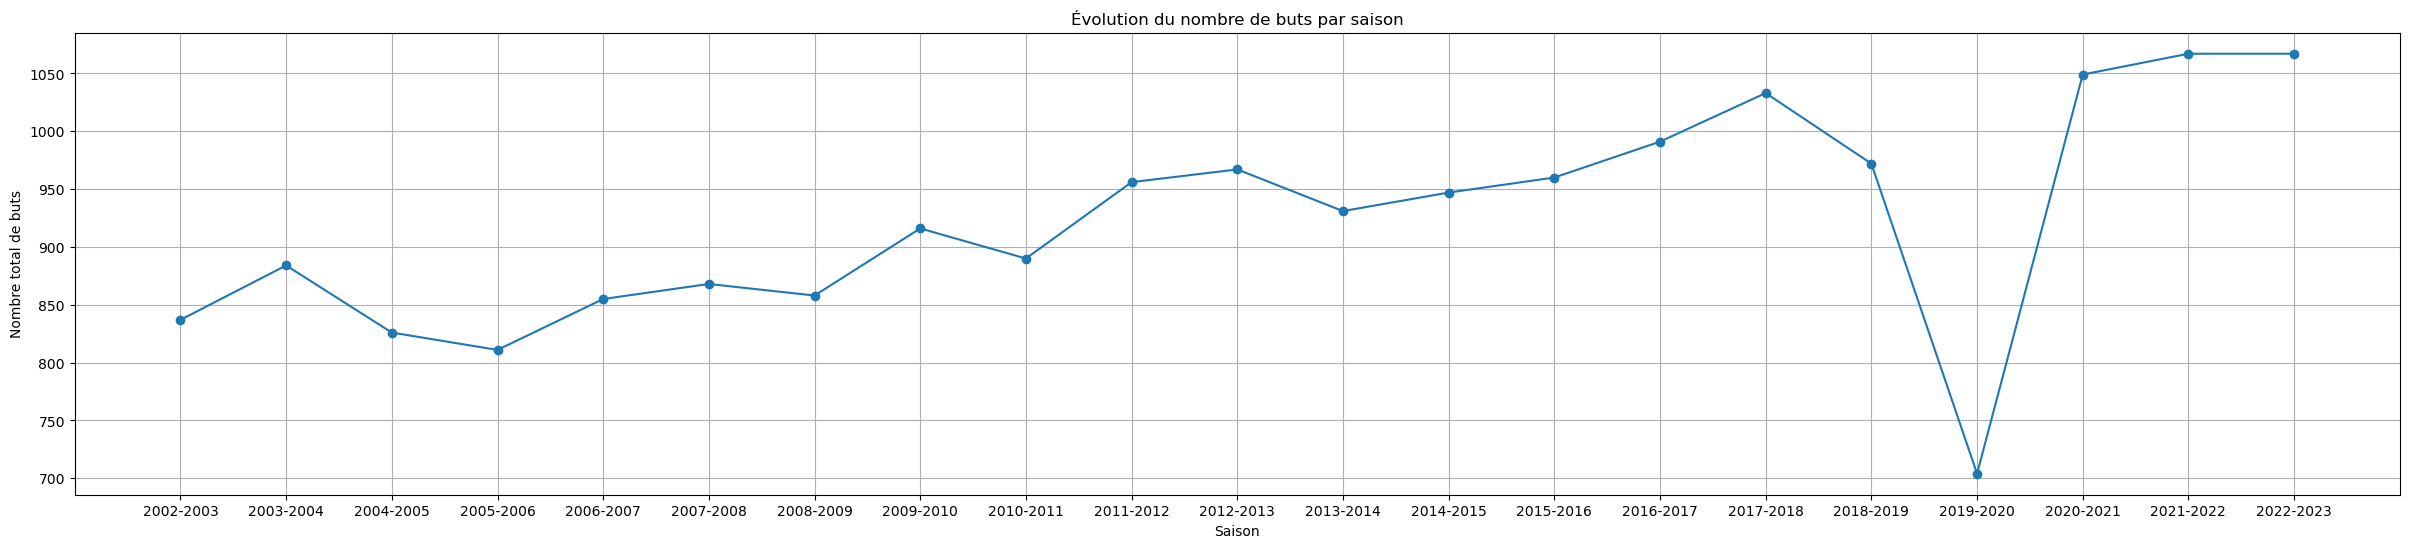

In [139]:
buts_par_saison = dataframe_stats.groupby('Saison')['Buts Equipe 1'].sum().reset_index()

plt.figure(figsize=(30, 6))
plt.plot(buts_par_saison['Saison'], buts_par_saison['Buts Equipe 1'], marker='o', linestyle='-')
plt.title('Évolution du nombre de buts par saison')
plt.xlabel('Saison')
plt.ylabel('Nombre total de buts')
plt.grid(True)
plt.show()

*On peut ensuite discriminer en fonction de Domicile/Extérieur et regarder les moyennes au lieu du total*

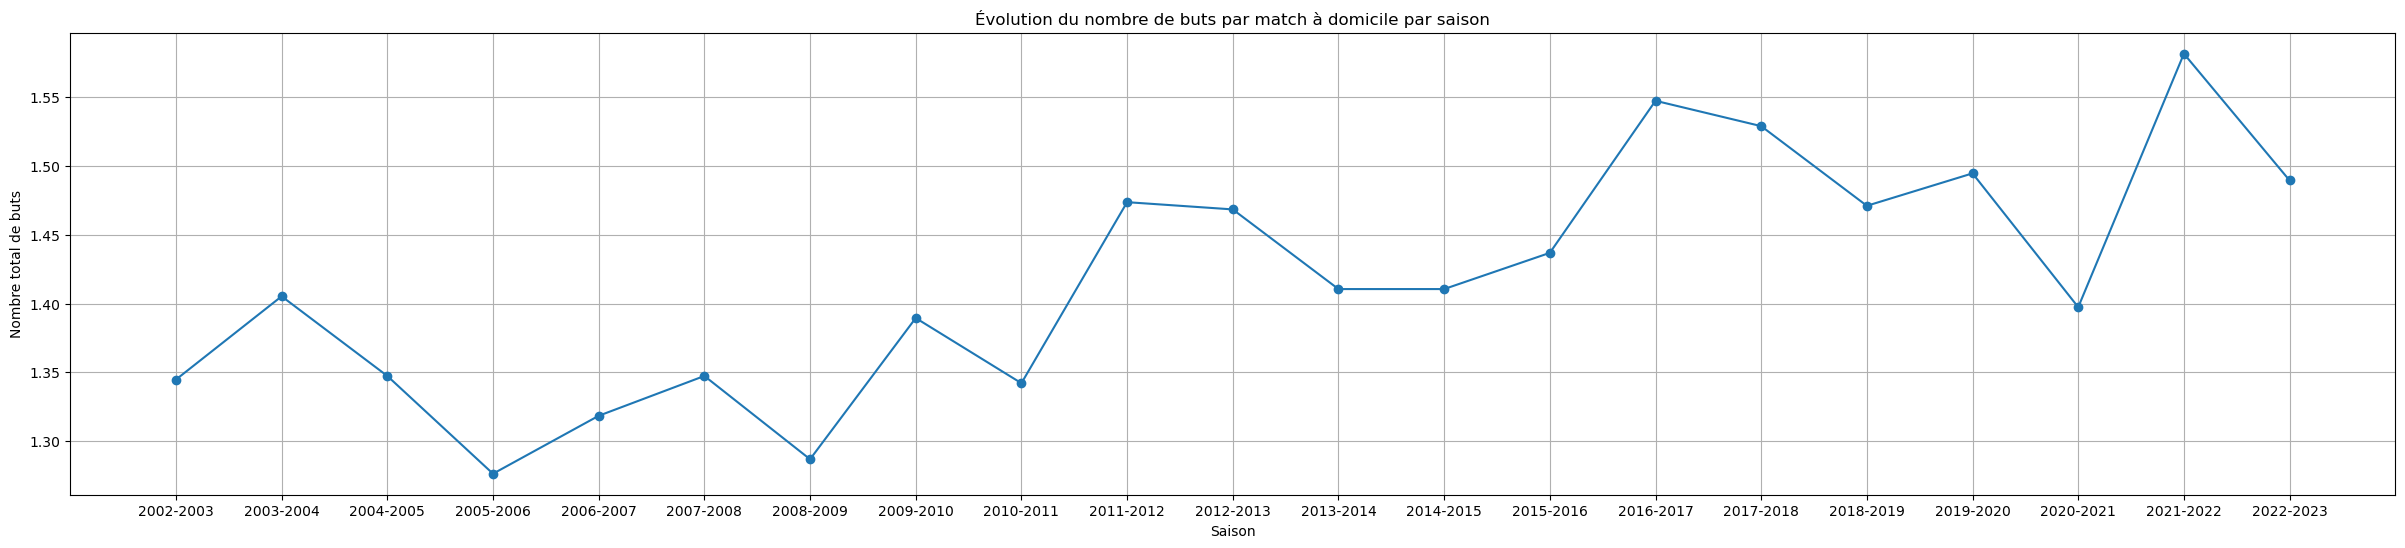

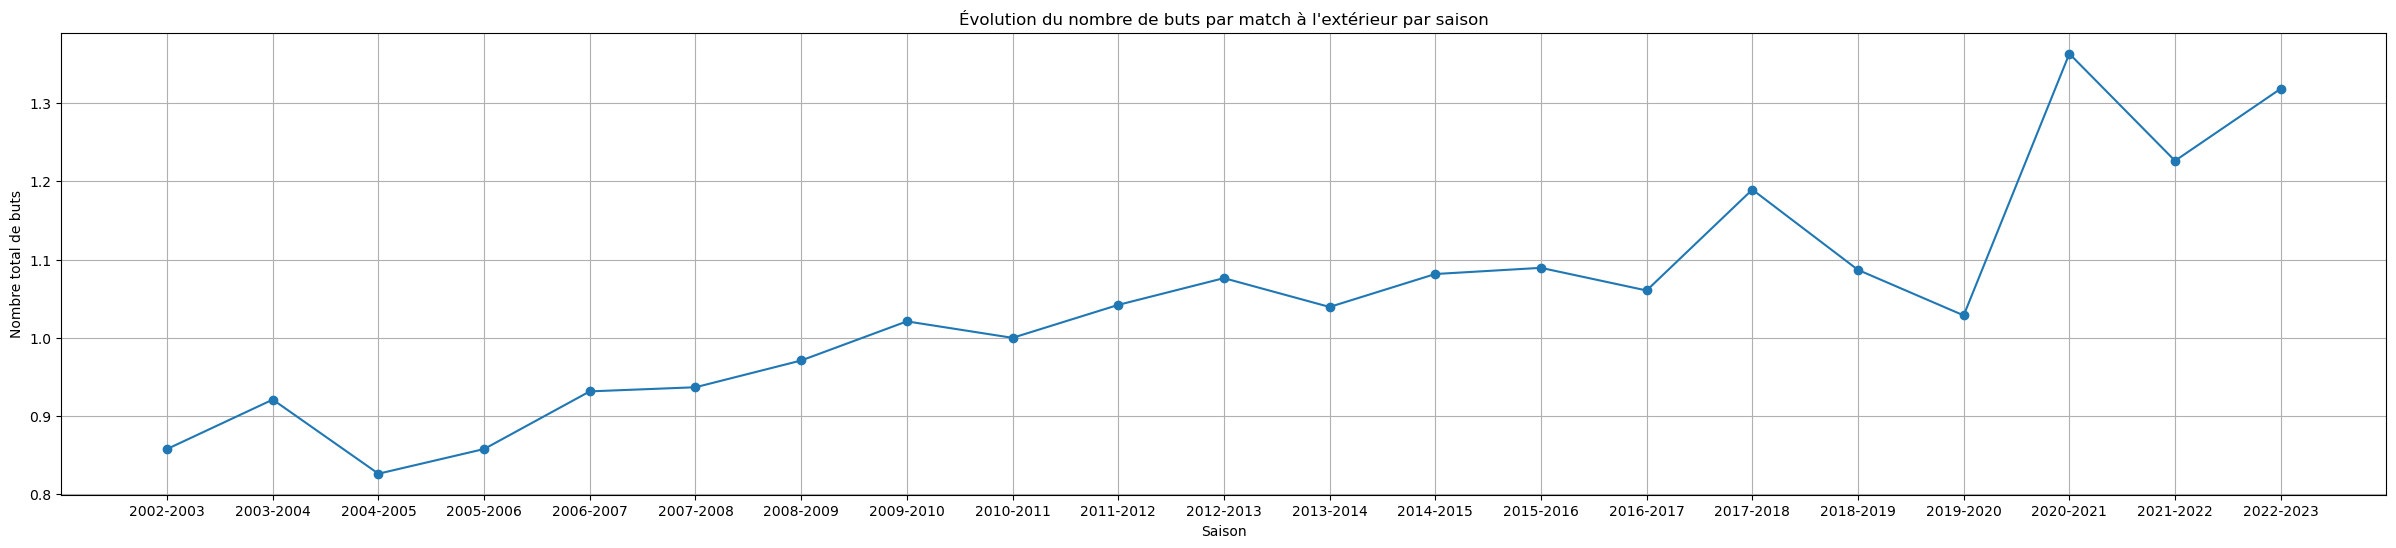

In [140]:
buts_par_saison = dataframe_stats[dataframe_stats['Lieu']=='Domicile'].groupby('Saison')['Buts Equipe 1'].mean().reset_index()

plt.figure(figsize=(30, 6))
plt.plot(buts_par_saison['Saison'], buts_par_saison['Buts Equipe 1'], marker='o', linestyle='-')
plt.title('Évolution du nombre de buts par match à domicile par saison')
plt.xlabel('Saison')
plt.ylabel('Nombre total de buts')
plt.grid(True)
plt.show()

buts_par_saison = dataframe_stats[dataframe_stats['Lieu']=='Extérieur'].groupby('Saison')['Buts Equipe 1'].mean().reset_index()

plt.figure(figsize=(30, 6))
plt.plot(buts_par_saison['Saison'], buts_par_saison['Buts Equipe 1'], marker='o', linestyle='-')
plt.title('Évolution du nombre de buts par match à l\'extérieur par saison')
plt.xlabel('Saison')
plt.ylabel('Nombre total de buts')
plt.grid(True)
plt.show()

*Regardons ensuite le nombre de buts par équipe sur la période*

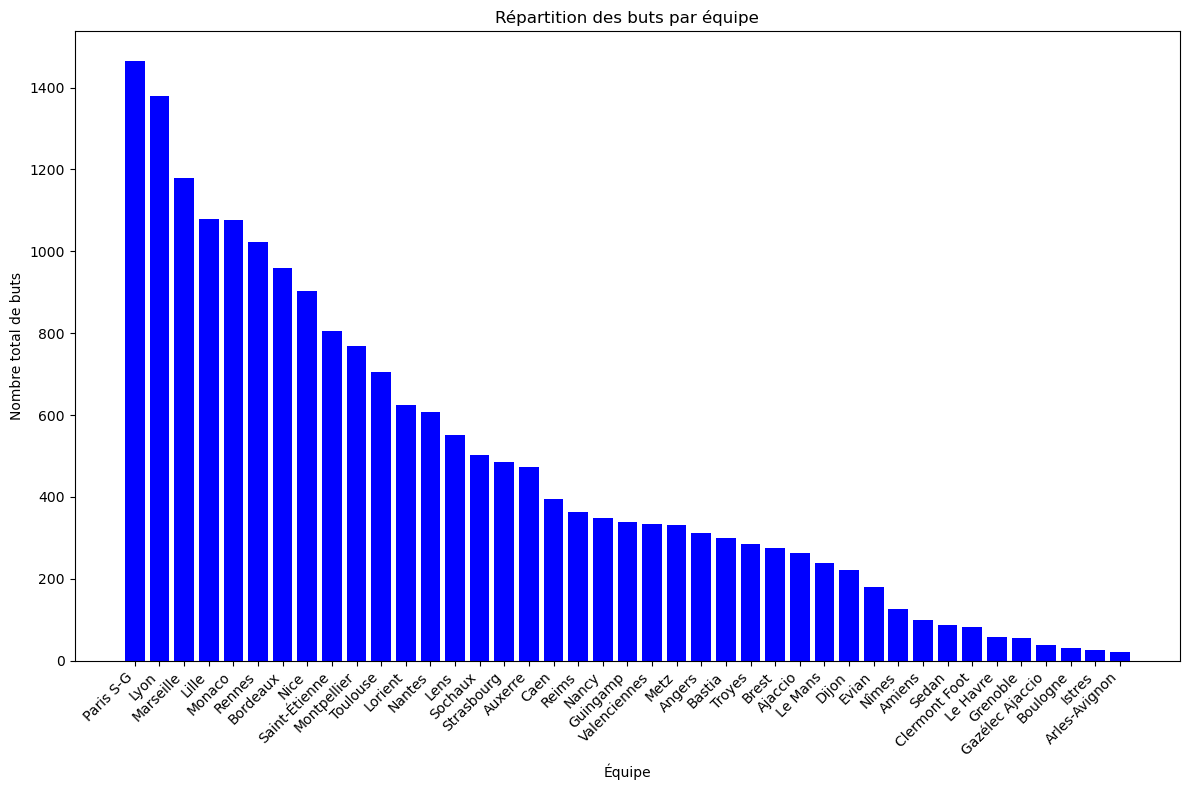

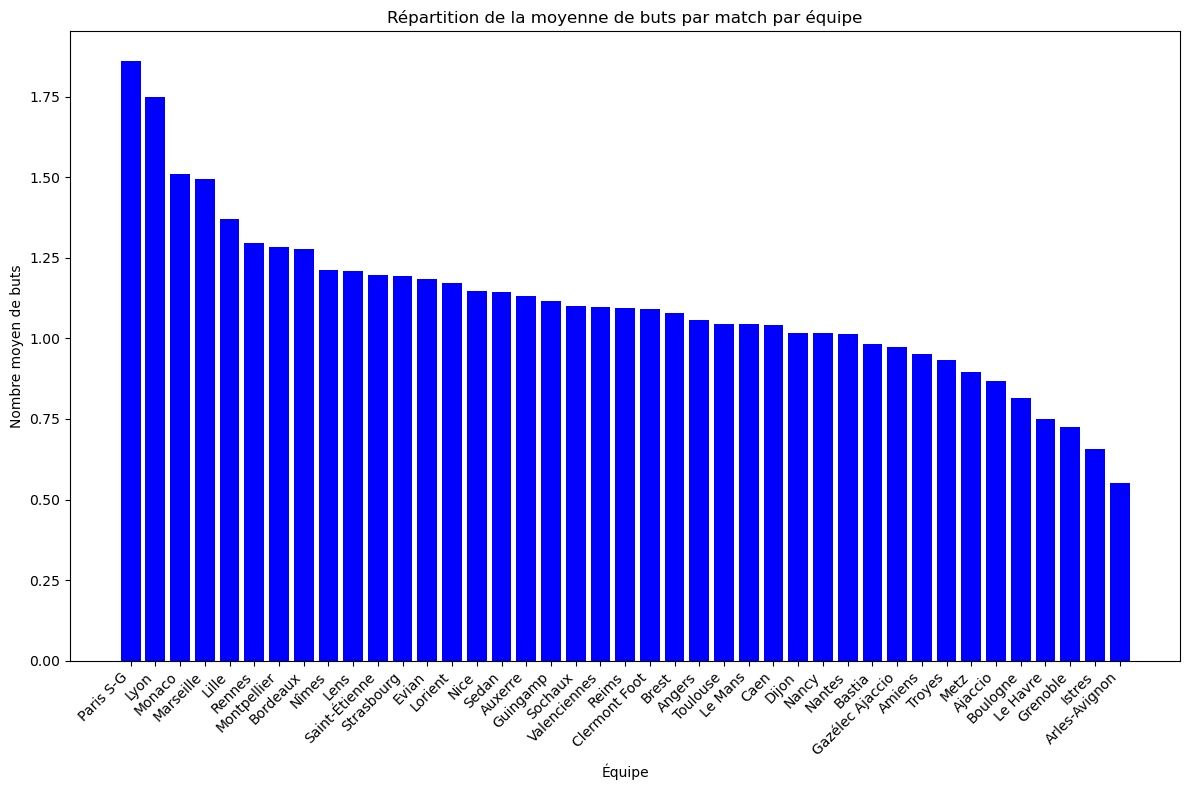

In [142]:
buts_par_equipe = dataframe_stats.groupby('Equipe 1')['Buts Equipe 1'].sum().reset_index()

buts_par_equipe = buts_par_equipe.sort_values(by='Buts Equipe 1', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(buts_par_equipe['Equipe 1'], buts_par_equipe['Buts Equipe 1'], color='blue')
plt.title('Répartition des buts par équipe')
plt.xlabel('Équipe')
plt.ylabel('Nombre total de buts')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

buts_par_equipe = dataframe_stats.groupby('Equipe 1')['Buts Equipe 1'].mean().reset_index()

buts_par_equipe = buts_par_equipe.sort_values(by='Buts Equipe 1', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(buts_par_equipe['Equipe 1'], buts_par_equipe['Buts Equipe 1'], color='blue')
plt.title('Répartition de la moyenne de buts par match par équipe')
plt.xlabel('Équipe')
plt.ylabel('Nombre moyen de buts')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

*On peut aussi regarder le nombre de points sur la période (Victoire = 3, Nul = 1, Défaite = 0)*

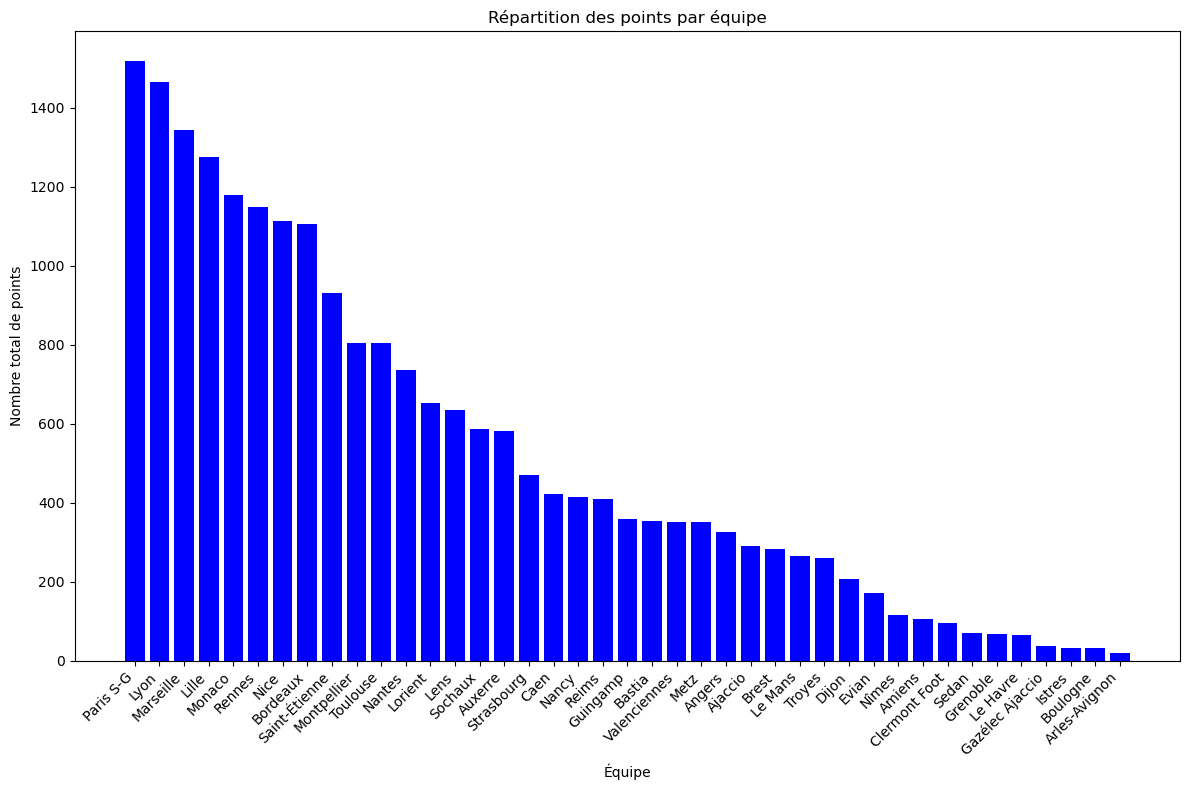

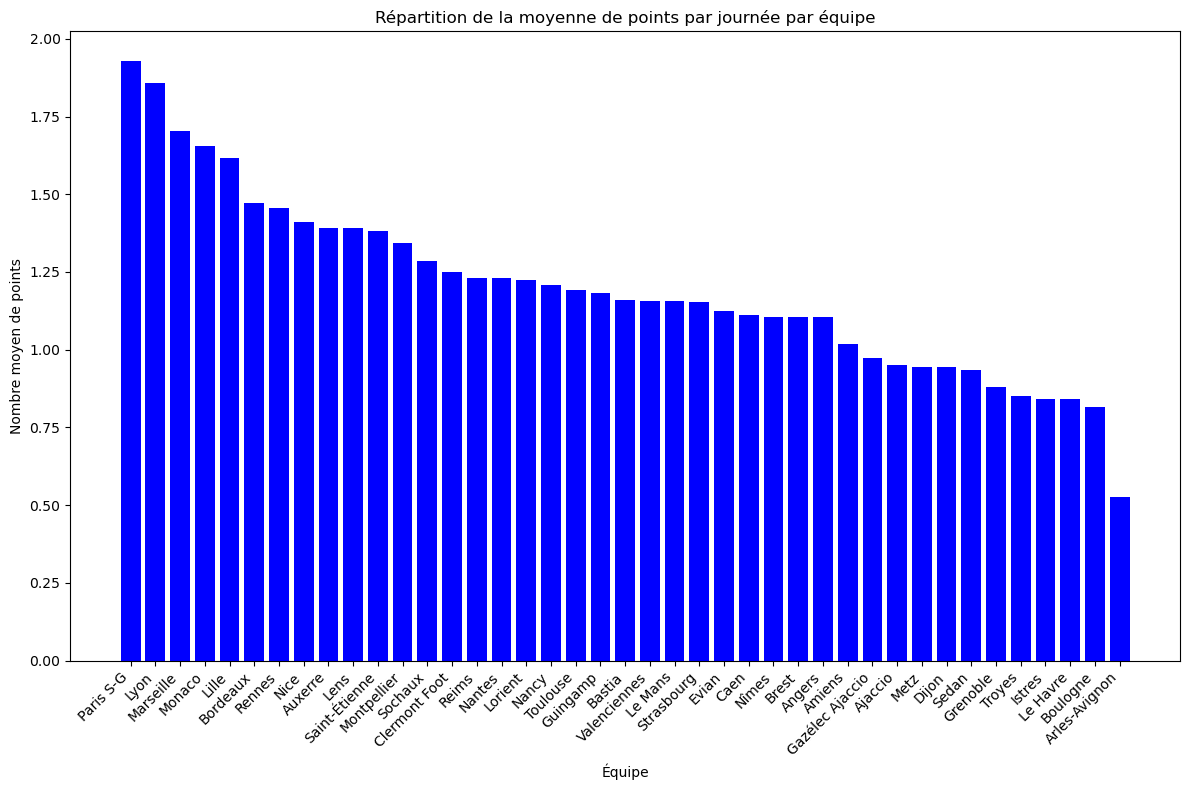

In [144]:
df_plot = dataframe_stats.copy()
df_plot['Résultat'] = df_plot['Résultat'].replace({'Défaite': 0, 'Nul': 1, 'Victoire': 3})

buts_par_equipe = df_plot.groupby('Equipe 1')['Résultat'].sum().reset_index()

buts_par_equipe = buts_par_equipe.sort_values(by='Résultat', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(buts_par_equipe['Equipe 1'], buts_par_equipe['Résultat'], color='blue')
plt.title('Répartition des points par équipe')
plt.xlabel('Équipe')
plt.ylabel('Nombre total de points')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

df_plot = dataframe_stats.copy()
df_plot['Résultat'] = df_plot['Résultat'].replace({'Défaite': 0, 'Nul': 1, 'Victoire': 3})

buts_par_equipe = df_plot.groupby('Equipe 1')['Résultat'].mean().reset_index()

buts_par_equipe = buts_par_equipe.sort_values(by='Résultat', ascending=False)

plt.figure(figsize=(12, 8))
plt.bar(buts_par_equipe['Equipe 1'], buts_par_equipe['Résultat'], color='blue')
plt.title('Répartition de la moyenne de points par journée par équipe')
plt.xlabel('Équipe')
plt.ylabel('Nombre moyen de points')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  
plt.show()

*Regardons le pourcentage de Victoire à Domicile. Pour l'extérieur il suffit d'inverser Victoire et Défaite*

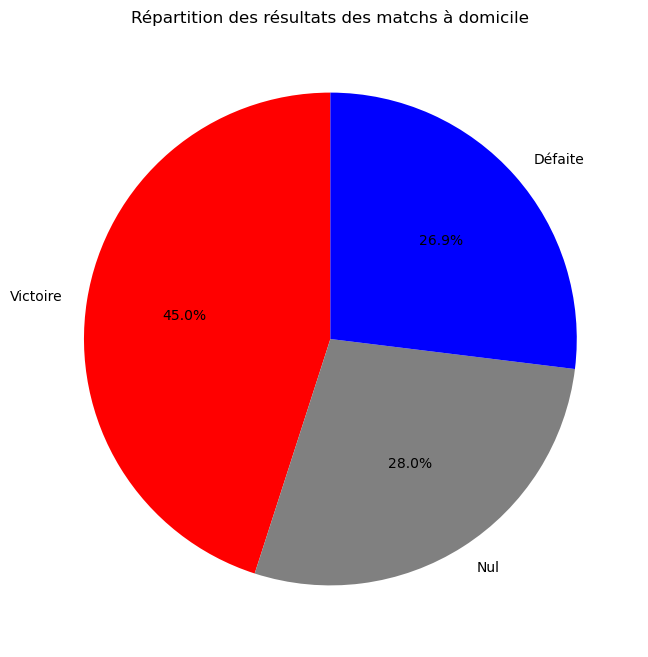

In [145]:
df_plot = dataframe_stats.copy()

result_counts = df_plot[df_plot['Lieu']=='Domicile']['Résultat'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'blue'])
plt.title('Répartition des résultats des matchs à domicile')
plt.show()

*On peut aussi regarder le pourcentage de Victoire contre des équipes moins bien classées*

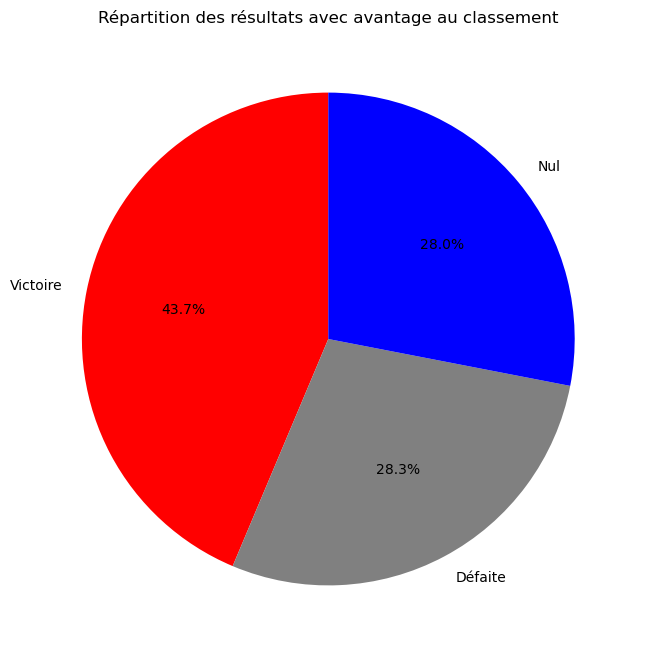

In [146]:
df_plot = dataframe_final.copy()
df_plot['Résultat'] = df_plot['Résultat'].replace({-1: 'Défaite', 0: 'Nul', 1: 'Victoire'})
result_counts = df_plot[df_plot['Classement Equipe 1']<=df_plot['Classement Equipe 2']]['Résultat'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=90, colors=['red', 'gray', 'blue'])
plt.title('Répartition des résultats avec avantage au classement')
plt.show()

*Analysons maintenant les occurences des scores avec deux méthodes différentes*

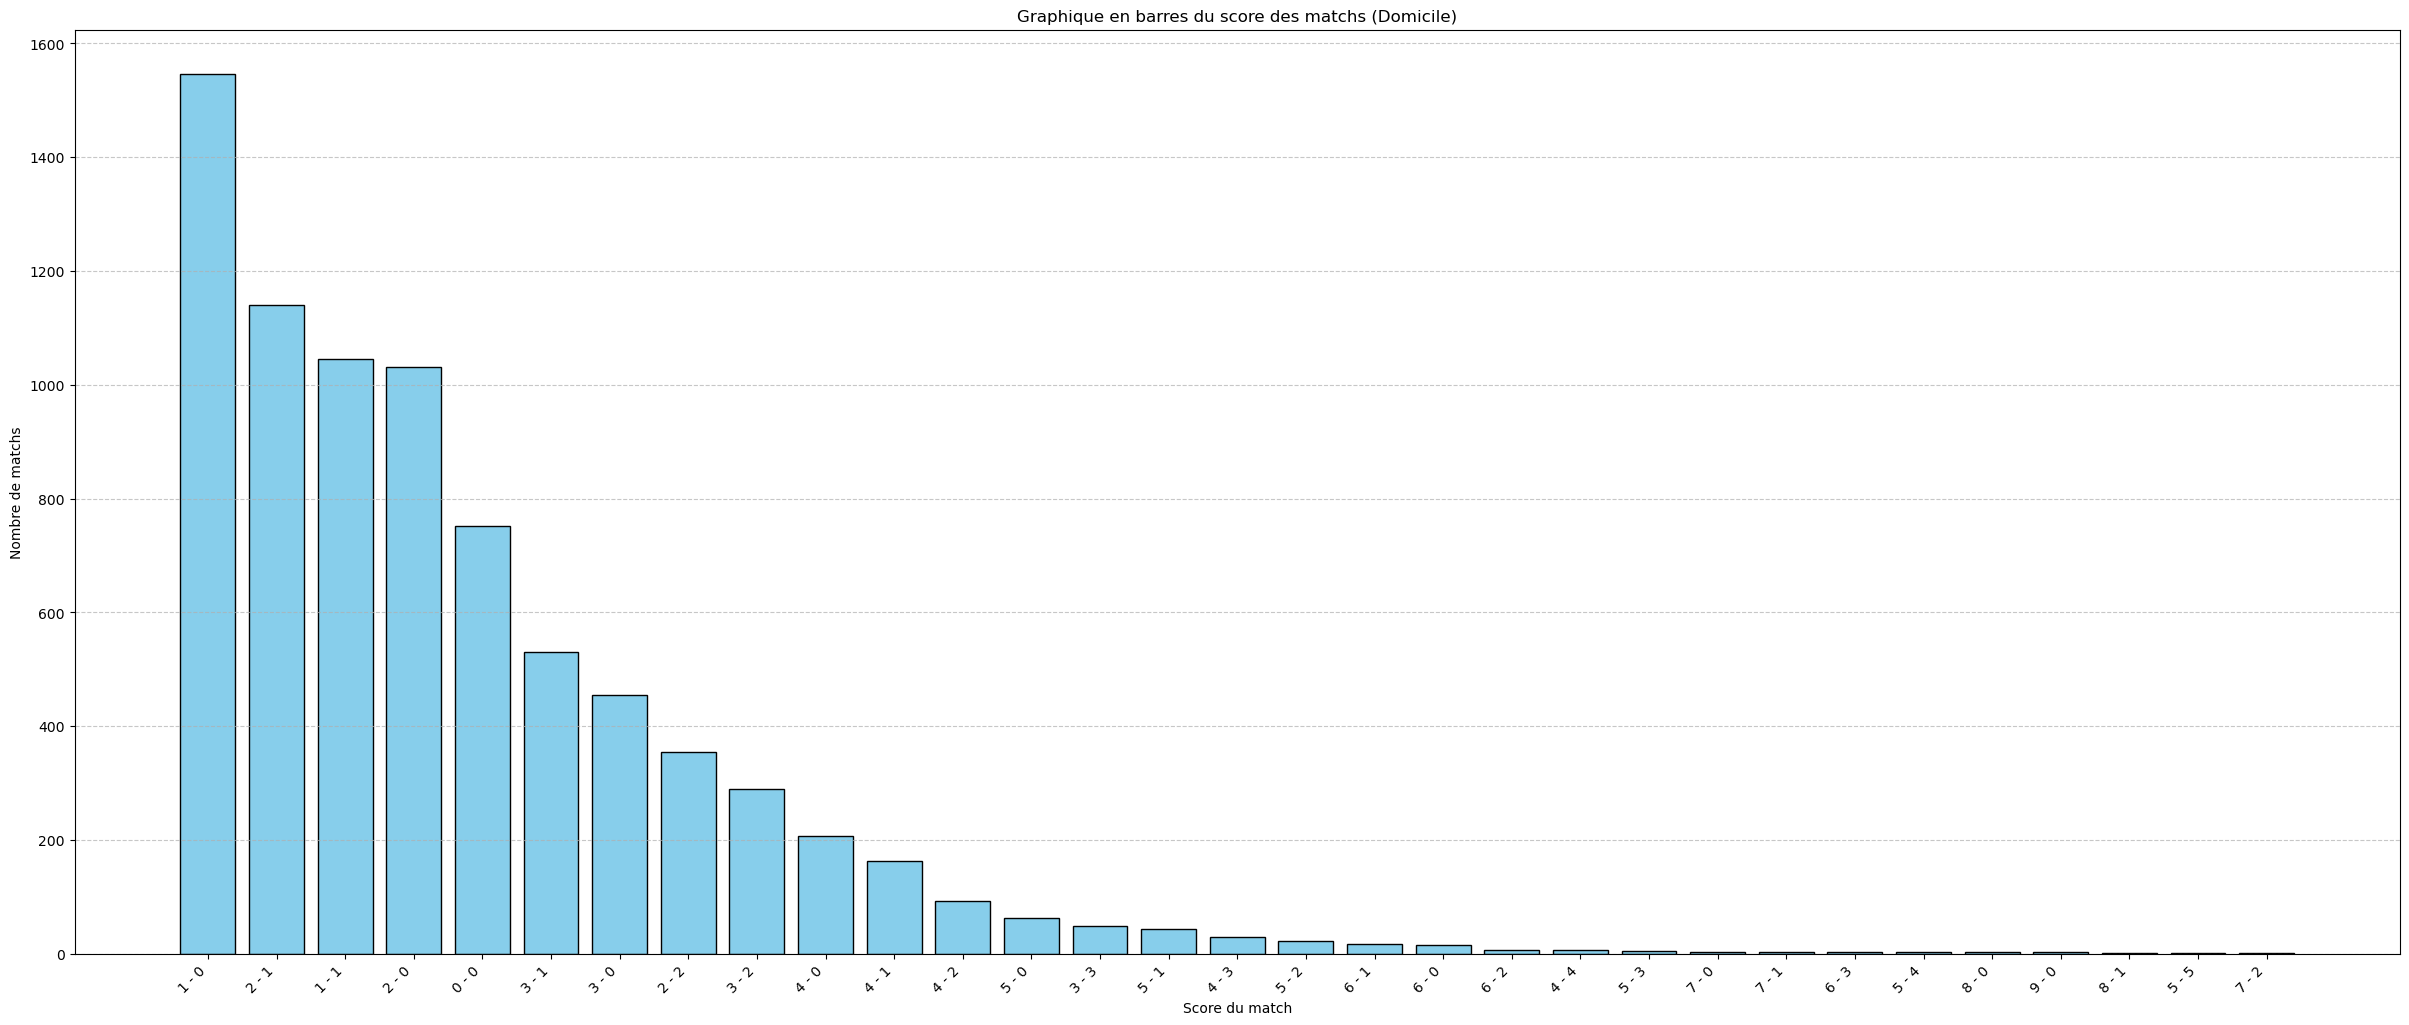

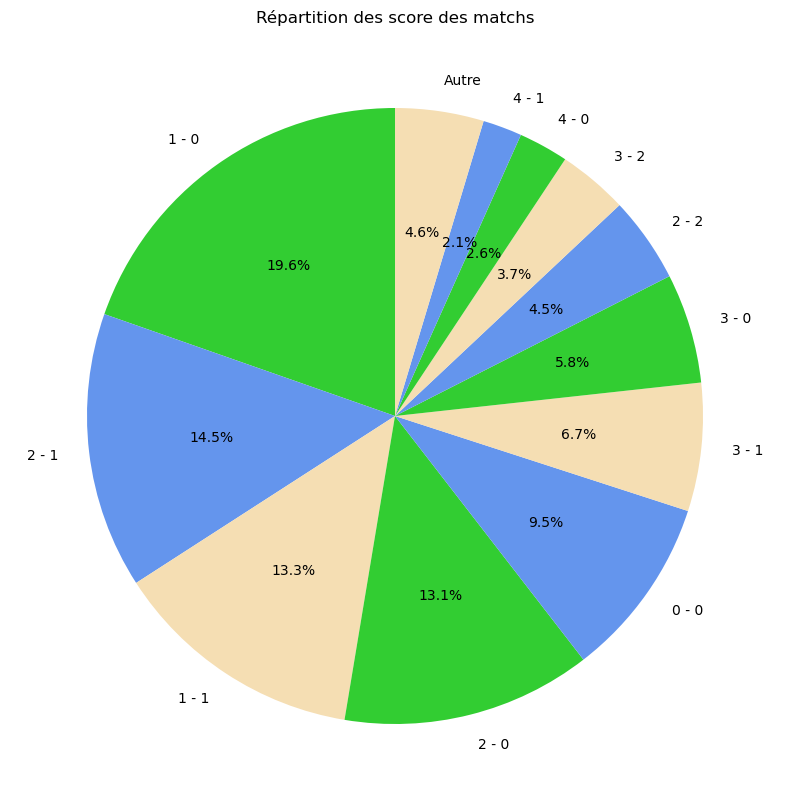

In [147]:
df_plot = dataframe_stats.copy()
df_plot['Score'] = df_plot.apply(lambda row: max(row['Buts Equipe 1'], row['Buts Equipe 2']), axis=1).astype(str) + ' - ' + df_plot.apply(lambda row: min(row['Buts Equipe 1'], row['Buts Equipe 2']), axis=1).astype(str) 
scores_categories = pd.Categorical(df_plot['Score'], categories=df_plot['Score'].unique(), ordered=True)

score_counts = df_plot[df_plot['Lieu'] == 'Domicile']['Score'].value_counts()

plt.figure(figsize=(30, 12))
plt.bar(range(len(score_counts)), score_counts, color='skyblue', edgecolor='black')
plt.title('Graphique en barres du score des matchs (Domicile)')
plt.xticks(range(len(score_counts)), score_counts.index, rotation=45, ha='right')
plt.xlabel('Score du match')
plt.ylabel('Nombre de matchs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

result_counts = df_plot[df_plot['Lieu']=='Domicile']['Score'].value_counts()
result_counts_grouped = result_counts.copy()
result_counts_grouped['Autre'] = result_counts[result_counts < 150].sum() 
result_counts_grouped = result_counts_grouped[result_counts_grouped >= 150]

plt.figure(figsize=(10, 10))
plt.pie(result_counts_grouped, labels=result_counts_grouped.index, autopct='%1.1f%%', startangle=90, colors=['limegreen', 'cornflowerblue', 'wheat'])
plt.title('Répartition des score des matchs')
plt.show()

*On peut enfin faire un graph en barres du nombre de buts totals par match*

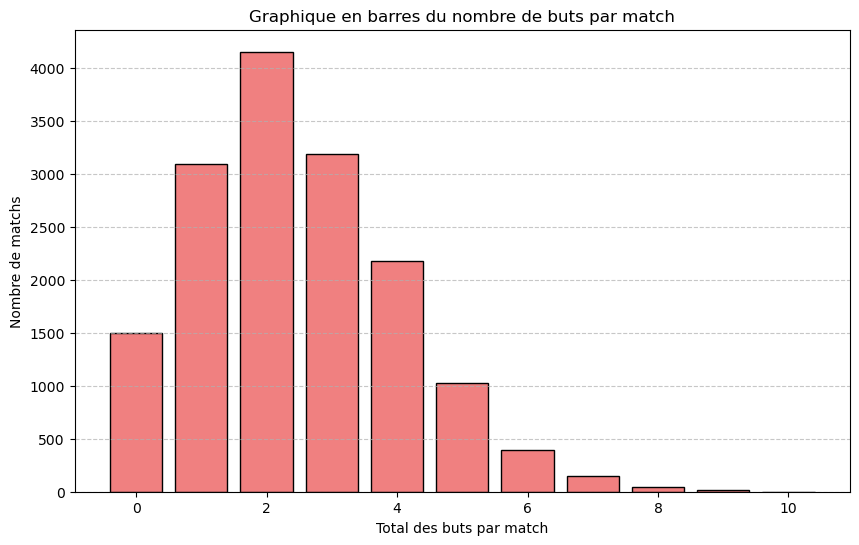

In [148]:
df_plot['Total Buts'] = df_plot['Buts Equipe 1'] + df_plot['Buts Equipe 2']

total_buts_counts = df_plot['Total Buts'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(total_buts_counts.index, total_buts_counts, color='lightcoral', edgecolor='black')

plt.title('Graphique en barres du nombre de buts par match')
plt.xlabel('Total des buts par match')
plt.ylabel('Nombre de matchs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Modélisation

Passons maintenant à la phase modélisation. Nous allons ici tester 3 modèles en modifiant les variables explicatives et même la variable expliquée. Ces modèles sont : **modèle de régression linéaire**, **Random Forest** et **modèle SVM**

Dans un premier temps, applicons ses 3 modèles avec comme variables expliquées le **Résultat** et le **Nombre de buts** de chaque équipe, et le reste des données numériques comme variables explicatives. On transforme le classement en 1/classement pour faciliter la régression et on accorde plus d'importances aux observations au fur et à mesure de la saiosn puisque les variables explicatives sont moins révélatrices en début de saison *(un classement à la 3ème journée est beaucoup moins révélateur qu'à la 37ème)*. 

In [163]:
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)  
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression['Diff classement'] = dataframe_regression['Classement Equipe 2'] - dataframe_regression['Classement Equipe 1']
dataframe_regression['Classement Equipe 1'] = 1/dataframe_regression['Classement Equipe 1']
dataframe_regression['Classement Equipe 2'] = 1/dataframe_regression['Classement Equipe 2']
X = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
X['poids'] = 1 + (dataframe_regression['Journée'] - 1) * 0.1
Y = dataframe_regression[["Résultat"]]
Z = dataframe_regression[["Buts Equipe 1"]]
W = dataframe_regression[["Buts Equipe 2"]]
X_train, X_test, Y_train, Y_test, Z_train, Z_test, W_train, W_test = train_test_split(X, Y, Z, W, test_size=0.2, random_state=42)
weights_train = X_train['poids']
X_train1 = X_train.drop(['poids'], axis=1)
X_test1 = X_test.drop(['poids'], axis=1)  

def fonction_appli_modeles(X_train, X_test, X_train1, X_test1, Y_train, Y_test, Z_train, Z_test, W_train, W_test):
    #Régression sur le résultat
    X_train1 = sm.add_constant(X_train1)
    X_test1 = sm.add_constant(X_test1)
    model = sm.WLS(Y_train.astype(float), X_train1.astype(float), weights=weights_train)
    results = model.fit()

    print(results.summary())

    Y_pred = results.predict(X_test1)
    Y_pred = [-1 if x < 0 else 1 for x in Y_pred]
    Y_test = Y_test[Y_test.columns[0]] .tolist()

    bon_résultat = [a == b for a, b in zip(Y_pred, Y_test)]

    accuracy = (sum(bon_résultat) / len(bon_résultat)) 
    print('Régression sur le Résultat')
    print('accuracy: ', accuracy)

    #Régression sur les Scores dont on déduit un Résultat
    model = sm.WLS(Z_train.astype(float), X_train1.astype(float), weights_train)
    results = model.fit()

    print(results.summary())

    Z_pred = results.predict(X_test1)
    Z_test = Z_test[Z_test.columns[0]] .tolist()

    model = sm.WLS(W_train.astype(float), X_train1.astype(float), weights = weights_train)
    results = model.fit()

    print(results.summary())

    W_pred = results.predict(X_test1)
    W_test = W_test[W_test.columns[0]] .tolist()

    resultat = [a - b for a, b in zip(Z_pred, W_pred)]
    Y_pred2 = [-1 if x < 0 else 1 for x in  resultat]
    bon_résultat = [a == b for a, b in zip(Y_pred2, Y_test)]

    accuracy = (sum(bon_résultat) / len(bon_résultat)) 
    print('Régression sur les Scores dont on déduit un Résultat')
    print('accuracy: ', accuracy)


    #Random Forest sur le résultat
    X_train['Classement Equipe 1'] = 1/X_train['Classement Equipe 1']     #On repasse les classements en mode classique pour les deux prochains modèles
    X_train['Classement Equipe 2'] = 1/X_train['Classement Equipe 2']
    X_test['Classement Equipe 1'] = 1/X_test['Classement Equipe 1']
    X_test['Classement Equipe 2'] = 1/X_test['Classement Equipe 2']
    random_forest_model.fit(X_train, Y_train)
    Y_pred3 = random_forest_model.predict(X_test)


    accuracy = accuracy_score(Y_test, Y_pred3)
    classification_report_result = classification_report(Y_test, Y_pred3)

    print('Random Forest sur le Résultat')
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report_result)

    #SVM model sur le résultat
    svm_model.fit(X_train, Y_train)

    Y_pred4 = svm_model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred4)
    classification_report_result = classification_report(Y_test, Y_pred4)

    print('SVM model sur le Résultat')
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report_result)

    return Y_test, Y_pred, Y_pred2, Y_pred3, Y_pred4

Y_test, Y_pred, Y_pred2, Y_pred3, Y_pred4 = fonction_appli_modeles(X_train, X_test, X_train1, X_test1, Y_train, Y_test, Z_train, Z_test, W_train, W_test)





                            WLS Regression Results                            
Dep. Variable:               Résultat   R-squared:                       0.125
Model:                            WLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     89.55
Date:                Wed, 27 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:42:29   Log-Likelihood:                -14562.
No. Observations:               11915   AIC:                         2.916e+04
Df Residuals:                   11895   BIC:                         2.931e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest sur le Résultat
Accuracy: 0.4820
Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.64      0.56      1083
           0       0.30      0.10      0.15       815
           1       0.51      0.61      0.55      1081

    accuracy                           0.48      2979
   macro avg       0.43      0.45      0.42      2979
weighted avg       0.45      0.48      0.44      2979



c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM model sur le Résultat
Accuracy: 0.4884
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.69      0.57      1083
           0       0.19      0.00      0.01       815
           1       0.50      0.65      0.56      1081

    accuracy                           0.49      2979
   macro avg       0.39      0.45      0.38      2979
weighted avg       0.41      0.49      0.41      2979



*On peut faire une tentative de pondération des modèles pour en sortir une prédiction plus précise. On teste donc différents poids associés aux modèles.*

In [165]:
n=0
for poids_modele1 in np.arange(0, 2, 0.2):
    for poids_modele2 in np.arange(0, 2, 0.2):
        for poids_modele3 in np.arange(0, 2, 0.2):
            for poids_modele4 in np.arange(0, 2, 0.2):  
                for k in np.arange(0,2,0.2):
                    Y_pred = np.array(Y_pred)
                    Y_pred2 = np.array(Y_pred2)
                    Y_pred3 = np.array(Y_pred3)
                    Y_pred4 = np.array(Y_pred4)

                    resultat_final_pondere = (
                        poids_modele1 * Y_pred +
                        poids_modele2 * Y_pred2 +
                        poids_modele3 * Y_pred3 +
                        poids_modele4 * Y_pred4
                    )
                    resultat_final = [1 if x > k else -1 if x < -k else 0 for x in resultat_final_pondere]

                    bon_résultat = [a == b for a, b in zip(resultat_final, Y_test)]

                    accuracy = (sum(bon_résultat) / len(bon_résultat)) 
                    if accuracy > n:
                        n= accuracy 
                        a = poids_modele1
                        b = poids_modele2
                        c = poids_modele3
                        d = poids_modele4
                        e = k
print('poids_modele1: ', a)
print('poids_modele2: ', b)
print('poids_modele3: ', c)
print('poids_modele4: ', d)
print('k: ', e)
print('accuracy: ', n)


poids_modele1:  0.4
poids_modele2:  0.2
poids_modele3:  0.2
poids_modele4:  0.2
k:  0.2
accuracy:  0.5025176233635448


On essaie ensuite de faire la méthode Random Forest sur les nombres de buts pour voir si cette méthode peut être employée

In [102]:
#Random Forest sur le Score
random_forest_model.fit(X_train, Z_train)
Z_pred= random_forest_model.predict(X_test)

random_forest_model.fit(X_train, W_train)
W_pred = random_forest_model.predict(X_test)

accuracy1 = accuracy_score(Z_test, Z_pred)
classification_report_result1 = classification_report(Z_test, Z_pred)

accuracy2 = accuracy_score(W_test, W_pred)
classification_report_result2 = classification_report(W_test, W_pred)

print('Random Forest sur Buts Equipe 1')
print(f"Accuracy: {accuracy1:.4f}")
print("Classification Report:\n", classification_report_result1)

print('Random Forest sur Buts Equipe 2')
print(f"Accuracy: {accuracy2:.4f}")
print("Classification Report:\n", classification_report_result2)

resultat = [a - b for a, b in zip(Z_pred, W_pred)]
Y_pred5 = [-1 if x < 0 else 1 for x in  resultat]
bon_résultat = [a == b for a, b in zip(Y_pred5, Y_test)]

accuracy = (sum(bon_résultat) / len(bon_résultat)) 
print('Régression sur les Scores dont on déduit un Résultat')
print('accuracy: ', accuracy)

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest sur Buts Equipe 1
Accuracy: 0.3521
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.42      0.40       893
           1       0.34      0.59      0.43      1034
           2       0.28      0.09      0.14       646
           3       0.25      0.02      0.04       252
           4       0.00      0.00      0.00       120
           5       0.00      0.00      0.00        26
           6       0.00      0.00      0.00         6
           7       0.00      0.00      0.00         2

    accuracy                           0.35      2979
   macro avg       0.16      0.14      0.13      2979
weighted avg       0.32      0.35      0.31      2979

Random Forest sur Buts Equipe 2
Accuracy: 0.3464
Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.39      0.38       898
           1       0.35      0.57      0.43      1042
           2       0.27      0.12      0

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\metr

Ce modèle n'est pas très concluant. On décide de l'abandonner

Ensuite on entraine de nouveaux nos modèles mais on modifie les variables explicatives. On ajoute les colonnes 'BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D', 'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D' et 'BE Equipe 2 à E si E', dont la valeur reprend celle des colonnes déjà existantes mais vaut 0 si le lieu ne correspond pas au match en question 

In [71]:
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression['Diff classement'] = dataframe_regression['Classement Equipe 2'] - dataframe_regression['Classement Equipe 1']
dataframe_regression['Classement Equipe 1'] = 1/dataframe_regression['Classement Equipe 1']
dataframe_regression['Classement Equipe 2'] = 1/dataframe_regression['Classement Equipe 2']
dataframe_regression[['BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D',
                      'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D', 'BE Equipe 2 à E si E']] = dataframe_regression.apply(
        lambda row: [row['Equipe 1 à Domicile'] * row['Moyenne_BM par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BM par 1 à Extérieur'], 
                     row['Equipe 1 à Domicile'] * row['Moyenne_BE par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur'],
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Extérieur'], 
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur']], axis=1, result_type='expand')
X = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat'], axis=1)
X['poids'] = 1 + (dataframe_regression['Journée'] - 1) * 0.1
Y = dataframe_regression[["Résultat"]]
Z = dataframe_regression[["Buts Equipe 1"]]
W = dataframe_regression[["Buts Equipe 2"]]
X_train, X_test, Y_train, Y_test, Z_train, Z_test, W_train, W_test = train_test_split(X, Y, Z, W, test_size=0.2, random_state=42)
weights_train = X_train['poids']
X_train1 = X_train.drop(['poids'], axis=1)
X_test1 = X_test.drop(['poids'], axis=1)  

fonction_appli_modeles(X_train, X_test, X_train1, X_test1, Y_train, Y_test, Z_train, Z_test, W_train, W_test)




                            WLS Regression Results                            
Dep. Variable:               Résultat   R-squared:                       0.123
Model:                            WLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     66.52
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          6.70e-314
Time:                        17:34:35   Log-Likelihood:                -14460.
No. Observations:               11915   AIC:                         2.897e+04
Df Residuals:                   11889   BIC:                         2.916e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest sur le Résultat
Accuracy: 0.4783
Classification Report:
               precision    recall  f1-score   support

          -1       0.49      0.64      0.56      1083
           0       0.28      0.09      0.14       815
           1       0.50      0.60      0.55      1081

    accuracy                           0.48      2979
   macro avg       0.43      0.45      0.42      2979
weighted avg       0.44      0.48      0.44      2979



c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM model sur le Résultat
Accuracy: 0.4807
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.66      0.56      1083
           0       0.28      0.06      0.10       815
           1       0.50      0.62      0.55      1081

    accuracy                           0.48      2979
   macro avg       0.42      0.45      0.40      2979
weighted avg       0.44      0.48      0.43      2979



Nos résultats ne sont pas meilleurs que précédemment. On décide donc ne pas essayer de pondérer les modèles dans ce cas là.

Enfin on essaie un dernier changement de variables explicatives en supprimant les colonnes 'Moyenne_BM par 1 à Domicile', 'Moyenne_BM par 1 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur','Moyenne_BM par 2 à Domicile','Moyenne_BM par 2 à Extérieur','Moyenne_BE par 1 à Domicile' et 'Moyenne_BE par 1 à Extérieur', qui sont inutiles maintenant et pourrait créer des perturbations dans nos modèles.

In [72]:
random_forest_model = RandomForestClassifier(n_estimators=1000, random_state=5)
svm_model = svm.SVC(kernel='rbf', C=50, random_state=42)
dataframe_regression = dataframe_final.dropna().copy()
dataframe_regression['Diff classement'] = dataframe_regression['Classement Equipe 2'] - dataframe_regression['Classement Equipe 1']
dataframe_regression['Classement Equipe 1'] = 1/dataframe_regression['Classement Equipe 1']
dataframe_regression['Classement Equipe 2'] = 1/dataframe_regression['Classement Equipe 2']
dataframe_regression[['BM Equipe 1 à D si D', 'BM Equipe 1 à E si E', 'BE Equipe 1 à D si D', 'BE Equipe 1 à E si E', 'BM Equipe 2 à D si D',
                      'BM Equipe 2 à E si E', 'BE Equipe 2 à D si D', 'BE Equipe 2 à E si E']] = dataframe_regression.apply(
        lambda row: [row['Equipe 1 à Domicile'] * row['Moyenne_BM par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BM par 1 à Extérieur'], 
                     row['Equipe 1 à Domicile'] * row['Moyenne_BE par 1 à Domicile'], (1 - row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur'],
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BM par 2 à Extérieur'], 
                     (1-row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Domicile'], (row['Equipe 1 à Domicile']) * row['Moyenne_BE par 1 à Extérieur']], axis=1, result_type='expand')
X = dataframe_regression.drop(['Equipe 1', 'Equipe 2', 'Saison', 'Journée', 'Buts Equipe 1', 'Buts Equipe 2', 'Résultat','Moyenne_BM par 1 à Domicile',
                                     'Moyenne_BM par 1 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur','Moyenne_BM par 2 à Domicile',
                                     'Moyenne_BM par 2 à Extérieur','Moyenne_BE par 1 à Domicile','Moyenne_BE par 1 à Extérieur'], axis = 1)
X['poids'] = 1 + (dataframe_regression['Journée'] - 1) * 0.1
Y = dataframe_regression[["Résultat"]]
Z = dataframe_regression[["Buts Equipe 1"]]
W = dataframe_regression[["Buts Equipe 2"]]
X_train, X_test, Y_train, Y_test, Z_train, Z_test, W_train, W_test = train_test_split(X, Y, Z, W, test_size=0.2, random_state=42)
weights_train = X_train['poids']
X_train1 = X_train.drop(['poids'], axis=1)
X_test1 = X_test.drop(['poids'], axis=1)  

fonction_appli_modeles(X_train, X_test, X_train1, X_test1, Y_train, Y_test, Z_train, Z_test, W_train, W_test)



                            WLS Regression Results                            
Dep. Variable:               Résultat   R-squared:                       0.122
Model:                            WLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     78.39
Date:                Tue, 26 Dec 2023   Prob (F-statistic):          2.15e-314
Time:                        17:37:17   Log-Likelihood:                -14467.
No. Observations:               11915   AIC:                         2.898e+04
Df Residuals:                   11893   BIC:                         2.914e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest sur le Résultat
Accuracy: 0.4743
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.63      0.55      1083
           0       0.26      0.08      0.12       815
           1       0.51      0.61      0.55      1081

    accuracy                           0.47      2979
   macro avg       0.42      0.44      0.41      2979
weighted avg       0.43      0.47      0.43      2979



c:\Users\vtgra\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM model sur le Résultat
Accuracy: 0.4807
Classification Report:
               precision    recall  f1-score   support

          -1       0.48      0.68      0.56      1083
           0       0.30      0.05      0.08       815
           1       0.49      0.61      0.55      1081

    accuracy                           0.48      2979
   macro avg       0.42      0.44      0.40      2979
weighted avg       0.44      0.48      0.43      2979

